<a href="https://colab.research.google.com/github/OlyKoek/Udemy-AIperfectMaster-colabo/blob/main/lstm_rnn_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなLSTMとRNNとTransformerの実装と比較

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, SimpleRNN, LSTM, Input, MultiHeadAttention, Add, LayerNormalization

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。

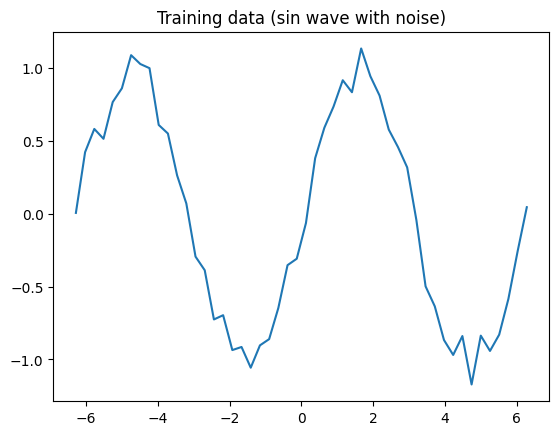

x: (40, 10, 1) t: (40, 10, 1)


In [3]:
x_data = np.linspace(-2*np.pi, 2*np.pi)
sin_data = np.sin(x_data) + 0.1 * np.random.randn(len(x_data))

plt.plot(x_data, sin_data)
plt.title("Training data (sin wave with noise)")
plt.show()

n_rnn = 10
n_sample = len(x_data) - n_rnn
x = np.zeros((n_sample, n_rnn))
t = np.zeros((n_sample, n_rnn))

for i in range(n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]

x = x.reshape(n_sample, n_rnn, 1)
t = t.reshape(n_sample, n_rnn, 1)
print("x:", x.shape, "t:", t.shape)


### テスト用の来予測関数を作成

In [4]:
def predict_future(model, x, n_rnn, steps=100):
    predicted = x[0].reshape(-1)
    for _ in range(len(x) + steps):
        y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1), verbose=0)
        predicted = np.append(predicted, y[0][-1][0])
    return predicted

### Simple LSTM

In [12]:
model_lstm = Sequential([
    LSTM(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_lstm.summary())

model_lstm.compile(loss="mse", optimizer="adam")
history_lstm = model_lstm.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_lstm = predict_future(model_lstm, x, n_rnn)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.4858 - val_loss: 0.6061
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4489 - val_loss: 0.5643
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4299 - val_loss: 0.5146
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4216 - val_loss: 0.4782
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3977 - val_loss: 0.4418
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3813 - val_loss: 0.4099
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3673 - val_loss: 0.3815
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3520 - val_loss: 0.3573
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3385 - val_loss: 0.3345
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3212 - val_loss: 0.3135
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3045 - val_loss: 0.2927
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2906 - val_loss: 0.

## Simple RNN
Kerasを使ってRNNを構築します。  
Kerasが持つRNNの中で一番シンプルなSimpleRNN層を使います。

In [ ]:
model_rnn = Sequential([
    SimpleRNN(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_rnn.summary())

model_rnn.compile(loss="mse", optimizer="adam")
history_rnn = model_rnn.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_rnn = predict_future(model_rnn, x, n_rnn)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.8313 - val_loss: 0.9346
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6947 - val_loss: 0.7815
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5804 - val_loss: 0.6608
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4779 - val_loss: 0.5646
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4082 - val_loss: 0.4834
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3494 - val_loss: 0.4145
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2992 - val_loss: 0.3551
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2641 - val_loss: 0.3047
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2379 - val_loss: 0.2670
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2139 - val_loss: 0.2365
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1884 - val_loss: 0.2135
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1705 - val_loss: 0.

### Simple Transformer

In [7]:
inputs = Input(shape=(n_rnn, 1))
x_tf = Dense(32)(inputs)  # embedding 的役割
attn_out = MultiHeadAttention(num_heads=2, key_dim=8)(x_tf, x_tf)
x_tf = Add()([x_tf, attn_out])  # 残差接続
x_tf = LayerNormalization()(x_tf)
x_tf = Dense(20, activation="relu")(x_tf)
outputs = Dense(1)(x_tf)
print(model_tf.summary())

model_tf = Model(inputs, outputs)
model_tf.compile(loss="mse", optimizer="adam")
history_tf = model_tf.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_tf = predict_future(model_tf, x, n_rnn)


## 損失関数の比較

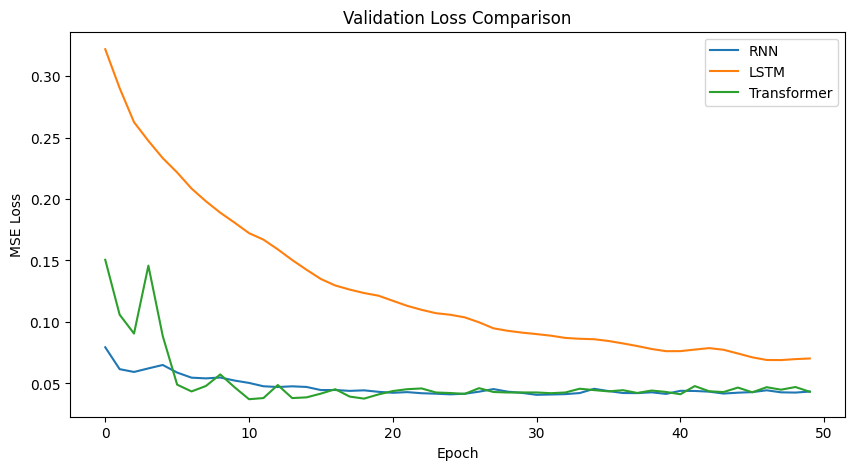

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history_rnn.history["val_loss"], label="RNN")
plt.plot(history_lstm.history["val_loss"], label="LSTM")
plt.plot(history_tf.history["val_loss"], label="Transformer")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## 推論による予測波形の表示

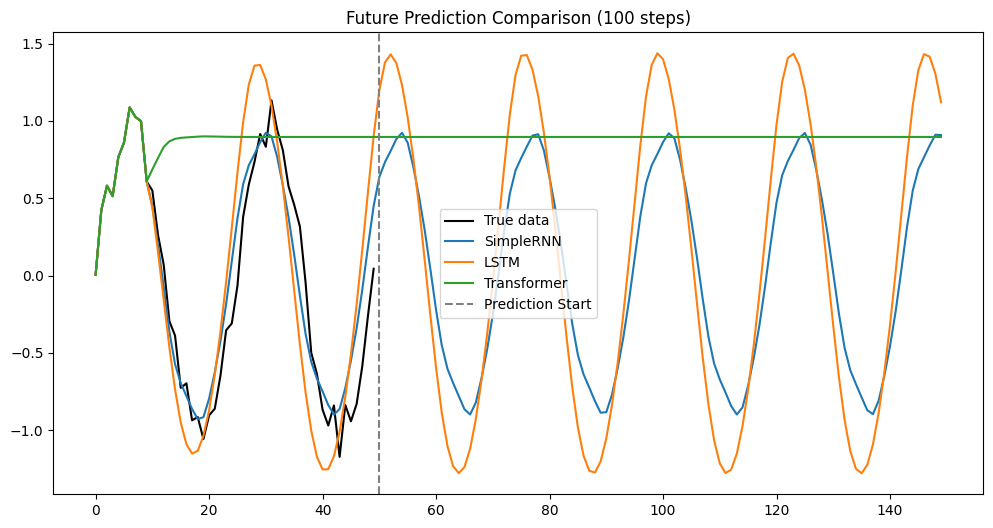

In [9]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(sin_data)), sin_data, label="True data", color="black", linewidth=1.5)
plt.plot(np.arange(len(pred_rnn)), pred_rnn, label="SimpleRNN")
plt.plot(np.arange(len(pred_lstm)), pred_lstm, label="LSTM")
plt.plot(np.arange(len(pred_tf)), pred_tf, label="Transformer")
plt.axvline(len(sin_data), color="gray", linestyle="--", label="Prediction Start")
plt.title("Future Prediction Comparison (100 steps)")
plt.legend()
plt.show()

## 学習
構築したRNNのモデルを使って、学習を行います。  

In [5]:
history = model.fit(x, t, epochs=20, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.5181 - val_loss: 0.3035
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3363 - val_loss: 0.2123
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2445 - val_loss: 0.1505
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1935 - val_loss: 0.1016
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1507 - val_loss: 0.1117
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1327 - val_loss: 0.0884
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1230 - val_loss: 0.0754
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1099 - val_loss: 0.0770
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1037 - val_loss: 0.0666
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0883 - val_loss: 0.0661
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0863 - val_loss: 0.0661
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0828 - val_loss: 0.0599
E

## 学習の推移
誤差の推移を確認します。

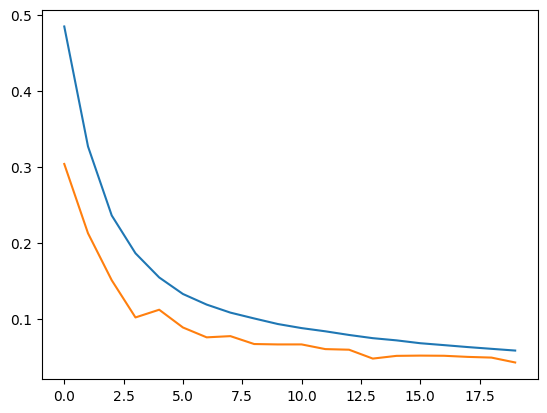

In [6]:
loss = history.history['loss']
vloss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(vloss)), vloss)
plt.show()

## 学習済みモデルの使用
RNNの学習済みモデルを使って、サイン関数の次の値を予測します。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

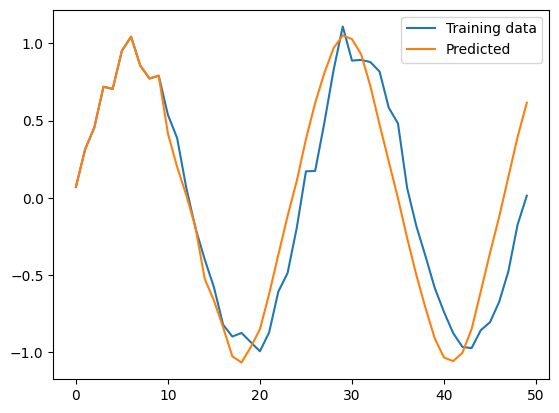

In [7]:
predicted = x[0].reshape(-1)  # 最初の入力。reshape(-1)で一次元のベクトルにする。

for i in range(0, n_sample):
    y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1))  # 直近のデータを使って予測を行う
    predicted = np.append(predicted, y[0][n_rnn-1][0])  # 出力の最後の結果をpredictedに追加する

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted)), predicted, label="Predicted")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━

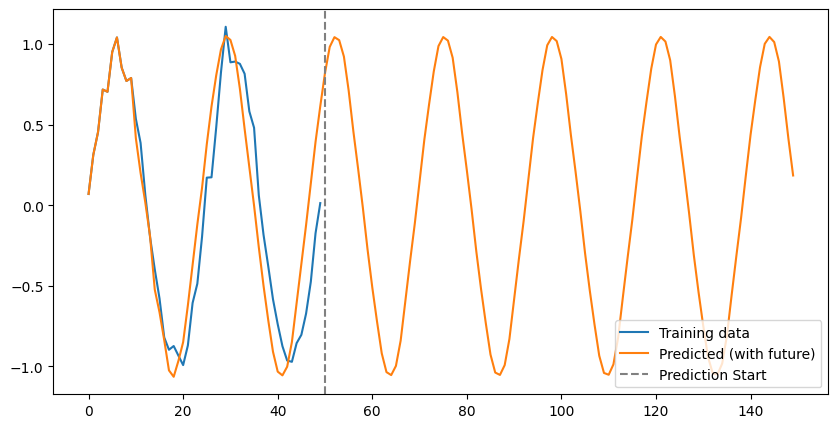

In [8]:
future_steps = 100   # 未来に予測したい点数
predicted = x[0].reshape(-1)  # 最初の入力系列（10点）

for i in range(n_sample + future_steps):  # 学習データ長 + 未来分
    y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1))
    predicted = np.append(predicted, y[0][n_rnn-1][0])  # 直近の最後の値を追加

# 結果を可視化
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted)), predicted, label="Predicted (with future)")
plt.axvline(len(sin_data), color="gray", linestyle="--", label="Prediction Start")
plt.legend()
plt.show()


In [15]:
from keras import layers, models

n_in = 1
n_rnn = 10

inputs = layers.Input(shape=(n_rnn, n_in))

# 🔸 自分自身をquery/key/valueとして渡す自己注意（Self-Attention）
attn_output = layers.MultiHeadAttention(
    num_heads=2, key_dim=8
)(inputs, inputs)

# 🔸 出力をDenseで整形
x = layers.Dense(20, activation="relu")(attn_output)
outputs = layers.Dense(1)(x)

model_tf = models.Model(inputs, outputs)
model_tf.compile(loss="mse", optimizer="adam")
model_tf.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │        113 │ input_layer_6[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10, 20)    │         40 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10, 1)     │         21 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174 (696.00 B)

 Trainable params: 174 (696.00 B)

 Non-trainable params: 0 (0.00 B)

In [1]:
model_tf.fit(x, t, epochs=50, batch_size=8, verbose=0)

def predict_future(model, x, steps=100):
    predicted = x[0].reshape(-1)
    for _ in range(len(x) + steps):
        y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1), verbose=0)
        predicted = np.append(predicted, y[0][-1][0])
    return predicted

pred_tf = predict_future(model_tf, x)


NameError: name 'model_tf' is not defined